In [95]:
import glob
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from astropy import units as u 
from astropy.coordinates import SkyCoord
from gammapy.stats import WStatCountsStatistic
from magicctapipe.utils import (
    calc_angular_distance,
    check_tel_combination,
    get_dl2_mean,
)

In [3]:
# Display all columns of the pandas data frame:
pd.set_option('display.max_columns', None)

# Customize the pyplot figure:
plt.rcParams.update({
    'figure.figsize': (12, 9),
    'font.size': 15,
    'grid.linestyle': 'dotted',
})

# Get the default color cycle:
cls = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Load DL2 data

### Load input files and apply quality cuts:

In [4]:
# === Settings ===
data_mask = '/home/yoshiki.ohtani/Crab/2020_12_15/4.dl1_to_dl2/data/dl2/merged/*.h5'
quality_cuts = 'intensity_width_2 < 0.2'

# === Main ===
print('Loading the following input files:')

file_paths = glob.glob(data_mask)
file_paths.sort()

data_list = []

for path in file_paths:
    
    print(Path(path).name)
    
    df = pd.read_hdf(path, 'events/params')
    data_list.append(df)
    
input_data = pd.concat(data_list)
input_data.set_index(['obs_id', 'event_id', 'tel_id'], inplace=True)
input_data.sort_index(inplace=True)

check_tel_combination(input_data)

print('Applying the quality cuts:')
print(quality_cuts)

input_data.query(quality_cuts, inplace=True)
input_data['multiplicity'] = input_data.groupby(['obs_id', 'event_id']).size()
input_data.query('multiplicity > 1', inplace=True)

combo_types = check_tel_combination(input_data)
input_data = input_data.join(combo_types)

Loading the following input files:
dl2_LST-1_MAGIC.Run03265.h5
dl2_LST-1_MAGIC.Run03266.h5
dl2_LST-1_MAGIC.Run03267.h5
dl2_LST-1_MAGIC.Run03268.h5



In total 565818 stereo events are found:
m1_m2 (type 0): 81021 events (14.3%)
lst1_m1 (type 1): 49166 events (8.7%)
lst1_m2 (type 2): 101238 events (17.9%)
lst1_m1_m2 (type 3): 334393 events (59.1%)


Applying the quality cuts:
intensity_width_2 < 0.2



In total 521598 stereo events are found:
m1_m2 (type 0): 84552 events (16.2%)
lst1_m1 (type 1): 67816 events (13.0%)
lst1_m2 (type 2): 110700 events (21.2%)
lst1_m1_m2 (type 3): 258530 events (49.6%)


In [5]:
input_data.head(5)

obs_id_lst  event_id_lst   intensity         x  \
obs_id  event_id tel_id                                                   
5093711 1882     1           3265.0      213291.0  563.637323 -0.612568   
                 2              NaN           NaN  290.039062 -0.302226   
                 3              NaN           NaN  178.574219 -0.251598   
        1884     1           3265.0      213433.0  240.332830  0.494876   
                 3              NaN           NaN   52.742188  0.198661   

                                y         r         phi    length  \
obs_id  event_id tel_id                                             
5093711 1882     1       0.123275  0.624849  168.621615  0.074065   
                 2       0.111699  0.322207  159.716245  0.052958   
                 3       0.071062  0.261441  164.228178  0.148567   
        1884     1      -0.258083  0.558130  -27.542509  0.079081   
                 3      -0.168252  0.260337  -40.262227  0.025472   

                         length_uncertainty     width  width_uncertainty  \
obs_id  event_id tel_id                                                    
5093711 1882     1                 0.003811  0.043084           0.002209   
                 2                 0.001560  0.030104           0.001145   
                 3                 0.006885  0.030572           0.001377   
        1884     1                 0.004909  0.028582           0.002207   
                 3                 0.001628  0.007890           0.000628   

                               psi  skewness  kurtosis      slope  intercept  \
obs_id  event_id tel_id                                                        
5093711 1882     1       -9.956434 -0.477336  2.425838 -15.168607  15.886220   
                 2      -28.351680  0.022468  2.006568  -8.048335  24.880157   
                 3       12.571635  1.150621  2.533926 -15.539467  27.215714   
        1884     1       78.777449 -0.134149  1.884649  13.710322  17.801520   
                 3      -17.319846 -0.041161  1.861422  20.921322  21.116408   

                         intensity_width_1  intensity_width_2  pixels_width_1  \
obs_id  event_id tel_id                                                         
5093711 1882     1                     0.0                0.0             0.0   
                 2                     0.0                0.0             0.0   
                 3                     0.0                0.0             0.0   
        1884     1                     0.0                0.0             0.0   
                 3                     0.0                0.0             0.0   

                         pixels_width_2  n_pixels  n_islands   alt_tel  \
obs_id  event_id tel_id                                                  
5093711 1882     1                  0.0        23          1  0.699055   
                 2                  0.0        30          1  0.698988   
                 3                  0.0        22          2  0.698982   
        1884     1                  0.0        13          1  0.699056   
                 3                  0.0         5          1  0.698983   

                           az_tel     timestamp  multiplicity  event_type  \
obs_id  event_id tel_id                                                     
5093711 1882     1       1.467483  1.608068e+09             3         3.0   
                 2       1.467507  1.608068e+09             3         3.0   
                 3       1.467476  1.608068e+09             3         3.0   
        1884     1       1.467484  1.608068e+09             2         2.0   
                 3       1.467477  1.608068e+09             2         2.0   

                         alt_tel_mean  az_tel_mean         h_max        alt  \
obs_id  event_id tel_id                                                       
5093711 1882     1           0.699008     1.467489  10579.423046  39.219476   
                 2           0.699008     1.467489  10579

### Compute the mean of the DL2 parameters:

In [6]:
print('Computing the mean of the DL2 parameters...')
dl2_mean = get_dl2_mean(input_data)

print('\nExcluding M1+M2 events...')
dl2_mean.query('combo_type != 0', inplace=True)

print(f'--> Number of events: {len(dl2_mean)}')

Computing the mean of the DL2 parameters...

Excluding M1+M2 events...
--> Number of events: 437046


In [7]:
dl2_mean.head()

combo_type  gammaness  reco_energy   reco_alt    reco_az  \
obs_id  event_id                                                             
5093711 1882             3.0   0.278524     0.483559  39.891337  84.326800   
        1884             2.0   0.511708     0.109273  41.067206  82.938346   
        1885             3.0   0.000000     0.140846  39.572948  84.402781   
        1887             2.0   0.431042     0.138638  40.410894  82.604620   
        1889             2.0   0.363167     0.228753  40.270671  82.765634   

                   alt_tel    az_tel    reco_ra   reco_dec     ra_tel  \
obs_id  event_id                                                        
5093711 1882      0.699008  1.467489  84.058315  22.017134  83.964756   
        1884      0.699020  1.467480  83.226961  23.399041  83.964314   
        1885      0.699010  1.467490  84.360249  21.854652  83.964756   
        1887      0.699021  1.467481  83.992705  23.430969  83.964314   
        1889      0.699022  1.467482  84.094923  23.269952  83.964314   

                    dec_tel     timestamp  
obs_id  event_id                           
5093711 1882      22.247877  1.608068e+09  
        1884      22.248441  1.608068e+09  
        1885      22.247873  1.608068e+09  
        1887      22.248436  1.608068e+09  
        1889      22.248433  1.608068e+09

### Check the observation time:

In [69]:
times_first = dl2_mean.groupby(['obs_id'])['timestamp'].first()
times_last = dl2_mean.groupby(['obs_id'])['timestamp'].last()

obs_time = u.Quantity(np.sum(times_last - times_first), u.s)
print(f'Observation time: {obs_time.to(u.min):.2f}')

Observation time: 55.07 min


# Compute the angular distance from ON/OFF regions

Observation ID: 5093711


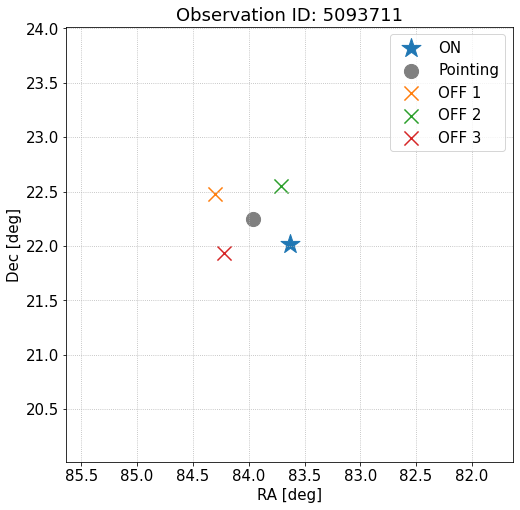

Observation ID: 5093712


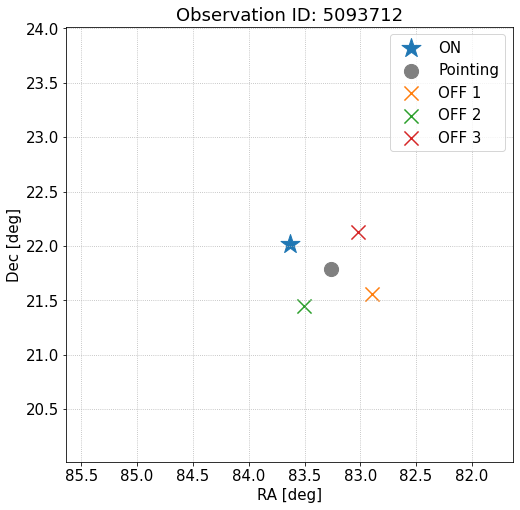

Observation ID: 5093713


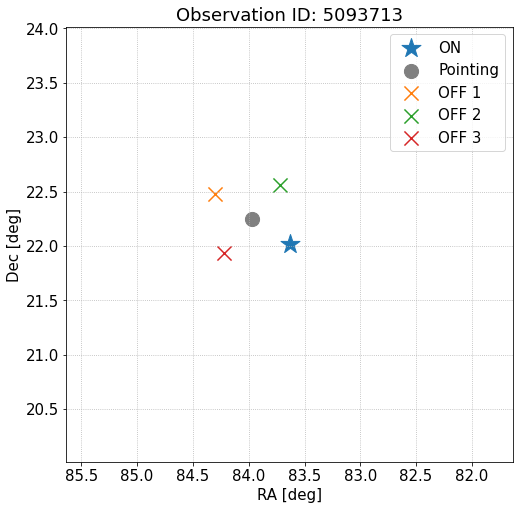

Observation ID: 5093714


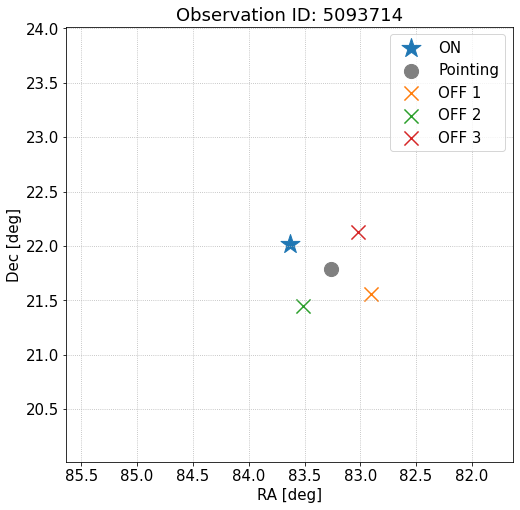

In [9]:
# === Settings ===
source_name = 'Crab'
n_off_regions = 3

# === Main ===
on_coord = SkyCoord.from_name(source_name)
on_coord = on_coord.transform_to('icrs')

xlim = [on_coord.ra.value + 2, on_coord.ra.value - 2]
ylim = [on_coord.dec.value - 2, on_coord.dec.value + 2]

observation_ids = np.unique(dl2_mean.index.get_level_values('obs_id'))

for obs_id in observation_ids:
    
    print(f'Observation ID: {obs_id}')
    df_obs = dl2_mean.query(f'obs_id == {obs_id}')
    
    event_coords = SkyCoord(
        ra=u.Quantity(df_obs['reco_ra'].to_numpy(), u.deg),
        dec=u.Quantity(df_obs['reco_dec'].to_numpy(), u.deg),
        frame='icrs',
    )
    
    tel_coords = SkyCoord(
        ra=u.Quantity(df_obs['ra_tel'].to_numpy(), u.deg),
        dec=u.Quantity(df_obs['dec_tel'].to_numpy(), u.deg),
        frame='icrs',
    )
    
    # Compute the angular distance from ON/OFF regions:
    theta_on, theta_off, off_coords = calc_angular_distance(
        on_coord, event_coords, tel_coords, n_off_regions,
    )
    
    dl2_mean.loc[(obs_id, slice(None)), 'theta2_on'] = theta_on.to(u.deg).value ** 2
    
    for i_off in theta_off.keys():
        dl2_mean.loc[(obs_id, slice(None)), f'theta2_off{i_off}'] = theta_off[i_off].to(u.deg).value ** 2
        
    # Plot the ON/OFF positions:
    plt.figure(figsize=(8, 8))
    plt.title(f'Observation ID: {obs_id}')
    plt.xlabel('RA [deg]')
    plt.ylabel('Dec [deg]')
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.axis(xlim+ylim)

    plt.scatter(
        on_coord.ra.value, on_coord.dec.value,
        label='ON', marker='*', s=400,
    )

    plt.scatter(
        tel_coords.ra.mean().value, tel_coords.dec.mean().value,
        label='Pointing', marker='o', s=200, color='grey',
    )
    
    for i_off in off_coords.keys():
        plt.scatter(
            off_coords[i_off].ra.value, off_coords[i_off].dec.value, 
            label=f'OFF {i_off}', marker='x', s=200, color=cls[i_off],
        )
    
    plt.grid()
    plt.legend()

    plt.show()
    plt.close()
    

# Check a signal from the source

### Count map:

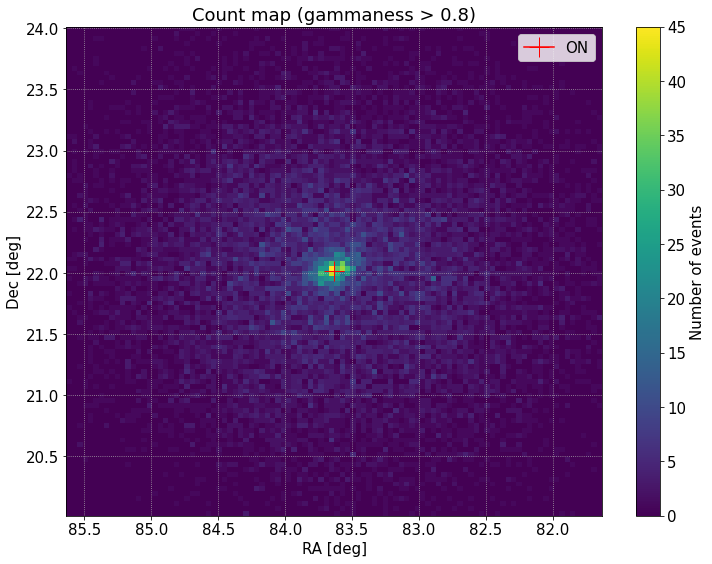

In [35]:
# === Settings ===
roi = 2
gam_cut = 0.8

# === Main ===
df = dl2_mean.query(f'gammaness > {gam_cut}')

xlim = [on_coord.ra.value + roi, on_coord.ra.value - roi]
ylim = [on_coord.dec.value - roi, on_coord.dec.value + roi]

plt.figure()
plt.title(f'Count map (gammaness > {gam_cut})')
plt.xlabel('RA [deg]')
plt.ylabel('Dec [deg]')
plt.xlim(xlim)
plt.ylim(ylim)

plt.hist2d(
    df['reco_ra'].to_numpy(), df['reco_dec'].to_numpy(),
    bins=[np.linspace(xlim[1], xlim[0], 101), np.linspace(ylim[0], ylim[1], 101)],
)

plt.plot(
    on_coord.ra.value, on_coord.dec.value, 
    marker='+', markersize=20, color='red', label='ON',
)

plt.axis(xlim+ylim)
plt.colorbar(label='Number of events')

plt.grid()
plt.legend()
plt.show()

### Theta2 distribution:

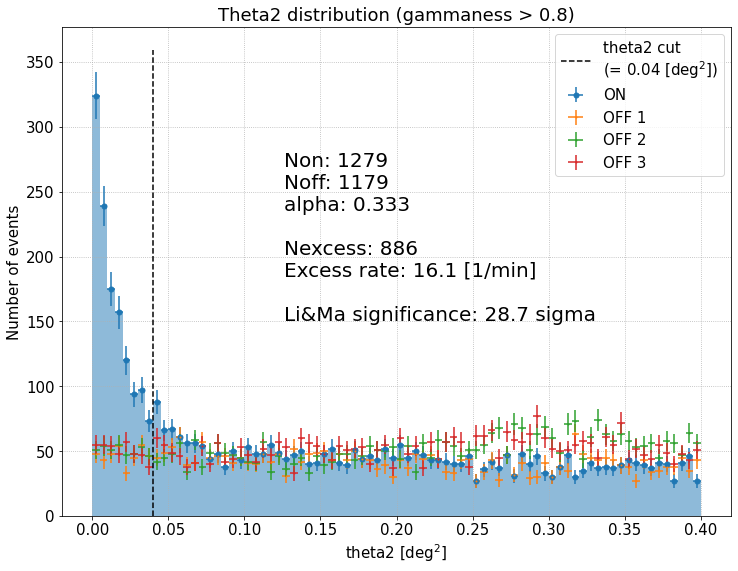

In [117]:
# === Settings ===
combo_types = [2, 3]
bins_t2 = np.linspace(0, 0.4, 81)

gam_cut = 0.8
t2_cut = 0.04

# === Main ===
bins_t2_center = (bins_t2[:-1] + bins_t2[1:]) / 2
xerr = [bins_t2_center - bins_t2[:-1], bins_t2[1:] - bins_t2_center]

df = dl2_mean.query(f'(combo_type == {combo_types}) & (gammaness > {gam_cut})')

plt.figure()
plt.title(f'Theta2 distribution (gammaness > {gam_cut})')
plt.xlabel('theta2 [deg$^2$]')
plt.ylabel('Number of events')

# Theta2 from the ON region:
hist = plt.hist(
    df['theta2_on'].to_numpy(), bins=bins_t2,
    histtype='bar', linewidth=2, alpha=0.5,
)

plt.errorbar(
    x=bins_t2_center, y=hist[0], xerr=xerr, yerr=np.sqrt(hist[0]), 
    fmt='o', markersize=5, label='ON', color=cls[0],
)

# Theta2 from the OFF regions:
for i_off in range(n_off_regions):
    
    hist, _ = np.histogram(
        df[f'theta2_off{i_off+1}'].to_numpy(), bins=bins_t2,
    )
    
    plt.errorbar(
        x=bins_t2_center, y=hist, xerr=xerr, yerr=np.sqrt(hist), 
        fmt='o', markersize=1, label=f'OFF {i_off+1}',
    )
    
plt.plot(
    (t2_cut, t2_cut), (0, plt.ylim()[1]), 
    linestyle='--', color='black', label=f'theta2 cut\n(= {t2_cut} [deg$^2$])',
)

# Compute the significance:
n_on = len(df.query(f'theta2_on < {t2_cut}'))
n_off = np.sum([len(df.query(f'theta2_off{i_off+1} < {t2_cut}')) for i_off in range(n_off_regions)])

alpha = 1 / n_off_regions
n_excess = n_on - alpha * n_off
excess_rate = n_excess / obs_time.to(u.min).value

stat = WStatCountsStatistic(n_on, n_off, alpha=alpha)
significance = stat.sqrt_ts

text = f'Non: {n_on}\nNoff: {n_off}\nalpha: {alpha:.3f}' \
       f'\n\nNexcess: {n_excess:.0f}\nExcess rate: {excess_rate:.1f} [1/min]' \
       f'\n\nLi&Ma significance: {significance:.1f} sigma'

plt.text(
    0.3 * plt.xlim()[1], 0.4 * plt.ylim()[1], text, fontsize=20,
)

plt.grid()
plt.legend()
plt.show()

### Theta2 distribution in each energy bin:

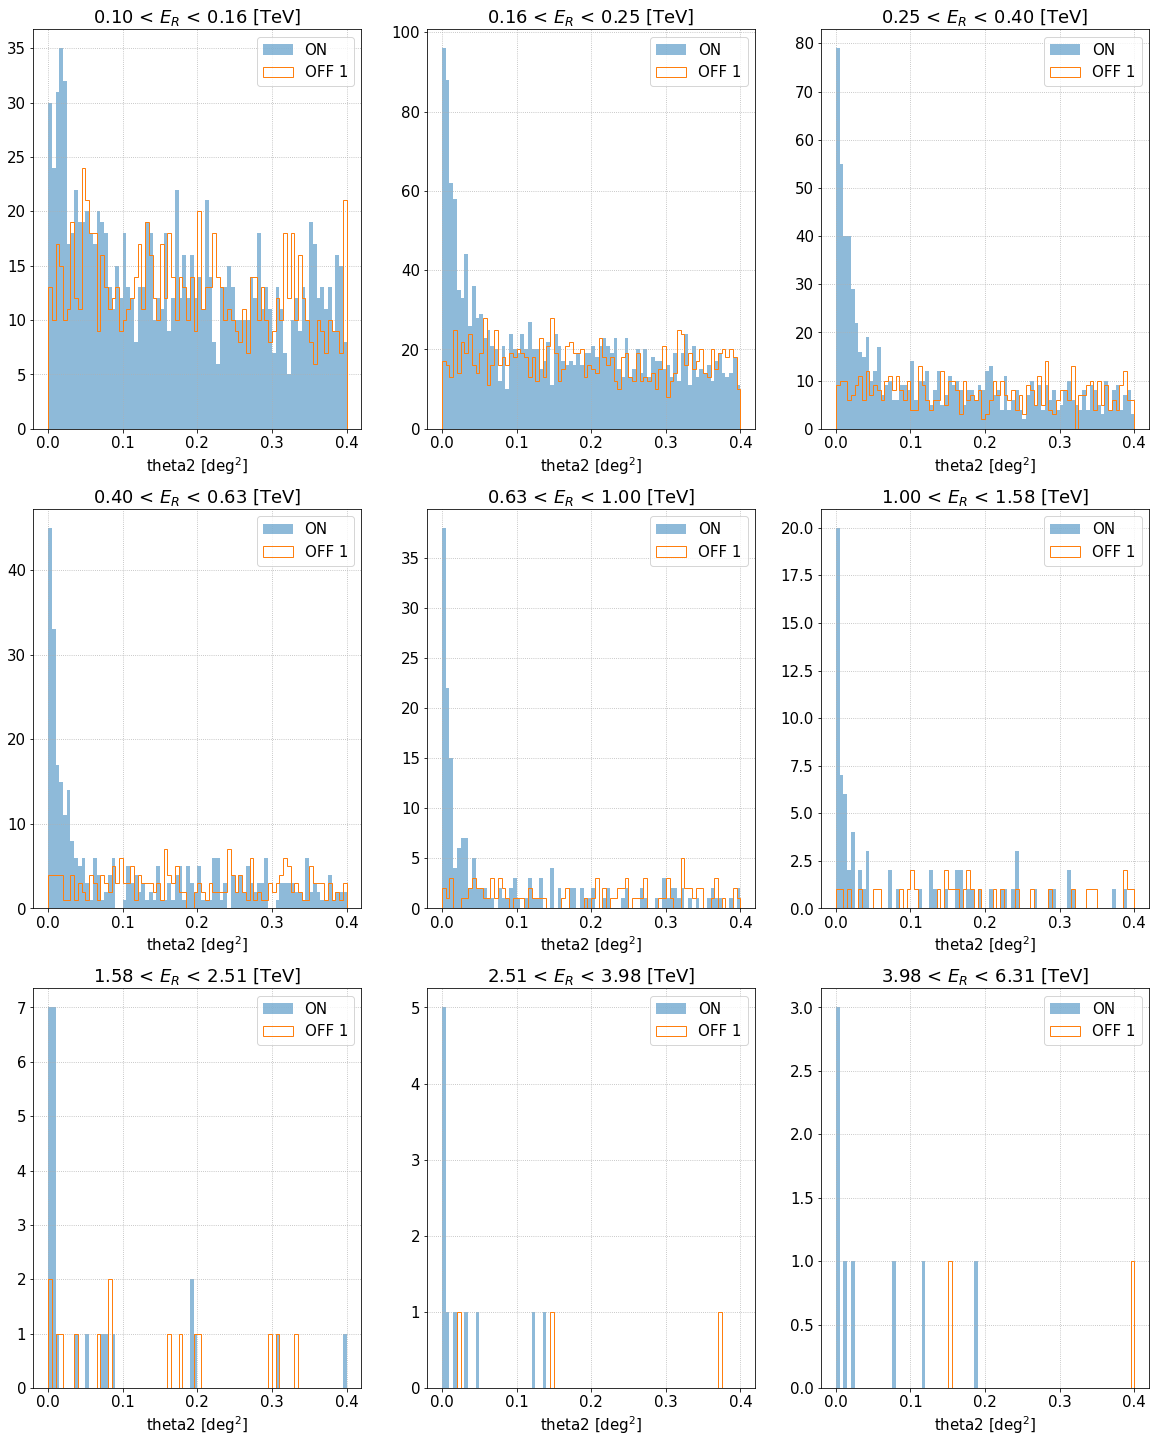

In [116]:
# === Settings ===
combo_types = [2, 3]
gam_cut = 0.8

bins_eng = np.logspace(-1, 1, 11)[:-1]
bins_t2 = np.linspace(0, 0.4, 81)

figsize = (20, 25)

# === Main ===
plt.figure(figsize=figsize)

grid = (int(np.ceil(len(bins_eng[:-1])/3)), 3)
locs = list(itertools.product(range(grid[0]), range(grid[1])))

for i_bin, (eng_lolim, eng_uplim) in enumerate(zip(bins_eng[:-1], bins_eng[1:])):
    
    event_cuts = f'(combo_type == {combo_types}) & (gammaness > {gam_cut}) ' \
                 f'& (reco_energy > {eng_lolim}) & (reco_energy < {eng_uplim})'
    
    df = dl2_mean.query(event_cuts)
    
    plt.subplot2grid(grid, locs[i_bin])
    plt.title(rf'{eng_lolim:.2f} < $E_R$ < {eng_uplim:.2f} [TeV]')
    plt.xlabel('theta2 [deg$^2$]')

    if len(df) > 0:
        plt.hist(
            df['theta2_on'].to_numpy(), bins=bins_t2,
            label='ON', histtype='bar', alpha=0.5,
        )
        
        hist = plt.hist(
            df['theta2_off1'].to_numpy(), bins=bins_t2,
            label='OFF 1', histtype='step', linewidth=1,
        )

    plt.grid()
    plt.legend(loc='upper right')
    
plt.show()